<a href="https://colab.research.google.com/github/mthomp89/MSDS462/blob/master/MSDS462_Final_Project__v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Data Ingest

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [2]:
!pip install tfcoreml

     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 3.4MB 13.2MB/s 


In [6]:

import tfcoreml


In [5]:
print("TensorFlow version {}".format(tf.__version__))
print("Eager mode: ", tf.executing_eagerly())
print("Is GPU available: ", tf.test.is_gpu_available())

TensorFlow version 1.15.0
Eager mode:  True
Is GPU available:  True


In [0]:
# Install TF 2.0
#!pip install tensorflow==2.0 -q

In [0]:
#import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
# Verify TF 2.0 installed
#!pip list | grep tensorflow

In [4]:
# Mount Gdrive where images stored
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# EDA

In [0]:
# Helper function for classification with pre-loaded ResNet50
def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    model = tf.keras.applications.resnet50.ResNet50()
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    print(decode_predictions(prediction, top=3)[0])

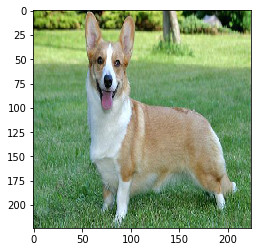

In [7]:
# Sample Images
cardigan_img_path = "/content/gdrive/My Drive/Colab Notebooks/pembroke-vs-cardigan/train/cardigan/OIP.jpg"
pembroke_img_path = "/content/gdrive/My Drive/Colab Notebooks/pembroke-vs-cardigan/train/pembroke/OIP.jpg"
cardigan_img = image.load_img(cardigan_img_path, target_size=(224, 224))
pembroke_img = image.load_img(pembroke_img_path, target_size=(224, 224))

plt.imshow(cardigan_img)
plt.show()

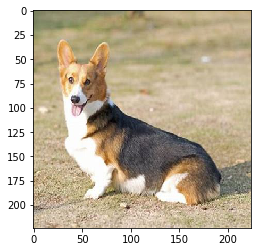

In [11]:
plt.imshow(pembroke_img)
plt.show()

In [13]:
# Sample Predictions
classify(cardigan_img_path)

40960/35363 [==================================] - 0s 0us/step
[('n02113023', 'Pembroke', 0.48588166), ('n02113186', 'Cardigan', 0.28688163), ('n02110806', 'basenji', 0.09196435)]


In [14]:
classify(pembroke_img_path)

[('n02113023', 'Pembroke', 0.7034617), ('n02113186', 'Cardigan', 0.2895212), ('n02110806', 'basenji', 0.005530551)]


# Modeling

In [0]:
# Setup variables
np.random.seed(42)
TRAIN_DATA_DIR = "/content/gdrive/My Drive/Colab Notebooks/pembroke-vs-cardigan/train/"
VALIDATION_DATA_DIR = "/content/gdrive/My Drive/Colab Notebooks/pembroke-vs-cardigan/val/"
TRAIN_SAMPLES = 35
VALIDATION_SAMPLES = 10
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
#BATCH_SIZE = 5

In [16]:
# Create generators
train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

val_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        shuffle=True,
                        seed=12345,
                        class_mode='categorical')
                        
validation_generator = val_datagen.flow_from_directory(
                        VALIDATION_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        shuffle=False,
                        class_mode='categorical')

Found 70 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [0]:
# Define Model & Freeze ResNet50 weights
def model_maker():
    base_model = ResNet50(include_top=False, input_shape =(IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [18]:
# Build and Train Model
model = model_maker()
model.compile(loss='categorical_crossentropy',
              optimizer= 'Adam',
              metrics=['acc'])

#num_steps = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)   

model.fit_generator(train_generator,
                    steps_per_epoch = None,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = None)

94773248/94765736 [==============================] - 4s 0us/step
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


3/3 [==============================] - 35s 12s/step - loss: 1.0777 - acc: 0.5000 - val_loss: 0.4827 - val_acc: 0.7500
Epoch 2/10
3/3 [==============================] - 1s 481ms/step - loss: 0.6968 - acc: 0.6571 - val_loss: 0.6091 - val_acc: 0.7500
Epoch 3/10
3/3 [==============================] - 2s 601ms/step - loss: 0.4387 - acc: 0.8000 - val_loss: 0.5511 - val_acc: 0.8500
Epoch 4/10
3/3 [==============================] - 2s 551ms/step - loss: 0.3021 - acc: 0.8143 - val_loss: 0.6121 - val_acc: 0.7500
Epoch 5/10
3/3 [==============================] - 2s 548ms/step - loss: 0.3652 - acc: 0.8286 - val_loss: 0.6595 - val_acc: 0.8500
Epoch 6/10
3/3 [==============================] - 2s 596ms/step - loss: 0.1714 - acc: 0.9143 - val_loss: 0.7086 - val_acc: 0.8500
Epoch 7/10
3/3 [==============================] - 2s 618ms/step - loss: 0.2881 - acc: 0.8571 - val_loss: 0.7546 - val_acc: 0.8500
Epoch 8/10
3/3 [==============================] - 2s 576ms/step - loss: 0.2966 - acc: 0.8714 - val_los

# Results

In [19]:
# VARIABLES
VALIDATION_BATCH_SIZE = 16 

# DATA GENERATORS
validation_datagen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=VALIDATION_BATCH_SIZE,
        shuffle=False,
        class_mode='categorical')
ground_truth = validation_generator.classes

fnames = validation_generator.filenames

Found 20 images belonging to 2 classes.


In [0]:
#predictions = model.predict_generator(validation_generator)

In [0]:
#predictions()

# Conversion to CoreML

In [0]:
model.save('corg-resnet50.h5')

In [21]:
!pip install --upgrade coremltools
!pip install --upgrade tfcoreml

Requirement already up-to-date: coremltools in /usr/local/lib/python3.6/dist-packages (3.3)
Requirement already up-to-date: tfcoreml in /usr/local/lib/python3.6/dist-packages (1.1)


In [22]:
'''
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import coremltools

model = load_model('corg-resnet50.h5')
coreml_model = coremltools.converters.keras.convert(model,
	input_names="image",
	image_input_names="image",
	image_scale=1/255.0,
	class_labels=['Cardigan','Pembroke'])

coreml_model.save('corg-resnet50.mlmodel')
'''
from keras.models import load_model
from tensorflow.keras.applications import ResNet50
import tfcoreml

#keras_model = ResNet50(weights=None, input_shape=(224, 224, 3))
#keras_model.save('corg-resnet50.h5')
model = tfcoreml.convert('corg-resnet50.h5',
                         input_name_shape_dict={'input_4': (1, 224, 224, 3)},
                         output_feature_names=['Identity'],
                         minimum_ios_deployment_target='13')
model.save('corg-resnet50.mlmodel')

0 assert nodes deleted
322 nodes deleted
159 nodes deleted
0 nodes deleted
[Op Fusion] fuse_bias_add() deleted 110 nodes.
2 identity nodes deleted
55 disconnected nodes deleted
[Op Fusion] Fused 318 nodes into BatchNorms.
[Op Fusion] Fused 1 Pad nodes into Conv2D.
[SSAConverter] Converting function main ...
[SSAConverter] [1/183] Converting op type: 'Placeholder', name: 'input_4', output_shape: (1, 224, 224, 3).
[SSAConverter] [2/183] Converting op type: 'Const', name: 'model/resnet50/pool1_pad/Pad/paddings', output_shape: (4, 2).
[SSAConverter] [3/183] Converting op type: 'Const', name: 'model/global_average_pooling2d/Mean/reduction_indices', output_shape: (2,).
[SSAConverter] [4/183] Converting op type: 'Transpose', name: 'input_4_to_nchw', output_shape: (1, 3, 224, 224).
[SSAConverter] [5/183] Converting op type: 'Conv2D', name: 'model/resnet50/conv1_conv/Conv2D', output_shape: (1, 64, 112, 112).
[SSAConverter] [6/183] Converting op type: 'BatchNorm', name: 'model/resnet50/conv1_bn/